In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
import os
import os.path as ops
from os.path import exists
import numpy as np
import glob
import cv2
import sys
import pandas as pd
from tensorflow.python.framework.ops import convert_to_tensor
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import img_to_array
import warnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
warnings.filterwarnings("ignore")




In [3]:
dataset_path = 'D:\\Project\\00_CommonTools\\data'
#dataset_path ='D:\\Project\\LaneNet_TF\\dataset'
train_path = 'D:\\Project\\LaneNet_TF\\dataset\\train.txt'
val_path = 'D:\\Project\\LaneNet_TF\\dataset\\val.txt'
test_path = 'D:\\Project\\LaneNet_TF\\dataset\\test.txt'



In [ ]:
def read_test():
    file = 'D:\\Project\\20_Carla0.9.5\\PythonAPI\\examples\\_out\\detect'
    img_path = []
    for idx, img in enumerate(glob.glob('{:s}/*.png'.format(file))):
        img_path.append(img)
    return img_path

In [ ]:
img_path = read_test()
print(img_path)

In [ ]:
def SRGBResize(im, size, filter):
    # Convert to numpy array of float
    arr = np.array(im, dtype=np.float32) / 255.0
    # Convert sRGB -> linear
    arr = np.where(arr <= 0.04045, arr/12.92, ((arr+0.055)/1.055)**2.4)
    # Resize using PIL
    arrOut = np.zeros((size[1], size[0], arr.shape[2]))
    for i in range(arr.shape[2]):
        chan = Image.fromarray(arr[:,:,i])
        chan = chan.resize(size, filter)
        arrOut[:,:,i] = np.array(chan).clip(0.0, 1.0)
    # Convert linear -> sRGB
    arrOut = np.where(arrOut <= 0.0031308, 12.92*arrOut, 1.055*arrOut**(1.0/2.4) - 0.055)
    # Convert to 8-bit
    arrOut = np.uint8(np.rint(arrOut * 255.0))
    # Convert back to PIL
    return Image.fromarray(arrOut)

In [ ]:
def GRResize(im, size, filter):
    # Convert to numpy array of float
    arr = np.array(im, dtype=np.float32) / 255.0
    # Convert sRGB -> linear
    arr = np.where(arr <= 0.04045, arr/12.92, ((arr+0.055)/1.055)**2.4)
    # Resize using PIL
    arrOut = np.zeros((size[1], size[0]))
    chan = Image.fromarray(arr[:,:,i])
    chan = chan.resize(size, filter)
    arrOut[:,:] = np.array(chan).clip(0.0, 1.0)
    # Convert linear -> sRGB
    arrOut = np.where(arrOut <= 0.0031308, 12.92*arrOut, 1.055*arrOut**(1.0/2.4) - 0.055)
    # Convert to 8-bit
    arrOut = np.uint8(np.rint(arrOut * 255.0))
    # Convert back to PIL
    return Image.fromarray(arrOut)

In [4]:
def read_txt(root, flag):
    img_path = []
    bin_path = []
    inst_path = []

    train_file = ops.join(root, 'train.txt')
    val_file = ops.join(root, 'val.txt')
    test_file = ops.join(root, 'test.txt')

    if flag == 'train':
        assert exists(train_file)
        file_open = train_file
    elif flag == 'valid':
        assert exists(val_file)
        file_open = val_file
    else:
        assert exists(test_file)
        file_open = test_file

    df = pd.read_csv(file_open, header=None, delim_whitespace=True, names=['img', 'bin', 'inst'])
    #print(df)
    img_path = df['img'].values
    bin_path = df['bin'].values
    inst_path = df['inst'].values

    #print(img_path)
    return img_path, bin_path, inst_path

In [5]:
import random
random.seed(10)
img_path, bin_path, inst_path = read_txt(dataset_path, 'train')
random.shuffle(img_path)
random.shuffle(bin_path)
random.shuffle(inst_path)
print(len(bin_path))


54935


In [6]:
img_path, bin_path, inst_path = img_path[0:6000], bin_path[0:6000], inst_path[0:6000]

In [ ]:
image_ds = tf.zeros([1,256, 512,3], tf.float32)
for i, image_name in enumerate(img_path):
    image = cv2.imread(image_name)
    image = Image.fromarray(image)
    image = image.resize((512,256))
    image = img_to_array(image)
    image = tf.math.divide(image, tf.constant(255, tf.uint8))
    image = tf.cast(image, dtype=tf.float32)
    image = tf.expand_dims(image,0)
    image_ds = tf.concat([image_ds, image],0)

In [7]:
image_ds = []
for i, image_name in enumerate(img_path):
    image = cv2.imread(image_name)
    image = Image.fromarray(image)
    image = image.resize((512,256))
    image_ds.append(np.array(image, dtype=np.float32))

In [ ]:
np.array(image_ds).shape

In [ ]:
v = tf.where(tf.math.is_nan(image_ds), 0, 1)
np.unique(np.array(v))

In [ ]:
mask_ds = tf.zeros([1,256, 512], tf.uint8)
for i, image_name in enumerate(bin_path):
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = image.resize((512,256))
    mask = tf.where(tf.math.equal(image, 255), 1, 0)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask,0)
    mask_ds = tf.concat([mask_ds, mask], 0)
mask_ds = tf.expand_dims(mask_ds,-1)

In [8]:
mask_ds = []
for i, image_name in enumerate(bin_path):
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = image.resize((512,256))
    label_binary = np.zeros([256, 512], dtype=np.uint8)
    mask = np.where(np.array(image)[:,:] != [0])
    print(np.unique(np.array(image)))
    label_binary[mask] = 1
    mask_ds.append(np.array(label_binary, dtype=np.uint8))
    

[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]
[  0 255]


In [ ]:
np.array(mask_ds).shape

In [ ]:
inst_ds = tf.zeros([1,256, 512,1], tf.float32)
for i, image_name in enumerate(inst_path):
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = image.resize((512,256))
    image = img_to_array(image)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.expand_dims(image,0)
    inst_ds = tf.concat([inst_ds, image],0)

In [9]:
inst_ds = []
for i, image_name in enumerate(inst_path):
    image = cv2.imread(image_name, 0)
    ex = image
    ex = Image.fromarray(ex)
    ex = ex.resize((512,256))
    print(np.unique(np.array(ex)))
    #np.unique(np.array(ex))
    ##label_inst = np.empty([256,512,1])
    #label_1 = np.zeros([256, 512], dtype=np.uint8)
    #label_2 = np.zeros([256, 512], dtype=np.uint8)
    #mask_1 = np.where(np.array(ex)[:,:] == [1])
    #mask_2 = np.where(np.array(ex)[:,:] == [2])
    #print(mask_1)
    #label_1[mask_1] = 1
    #label_2[mask_2] = 1
    #label_1 = np.expand_dims(label_1,axis=2)
    #label_2 = np.expand_dims(label_2,axis=2)
    #label_inst = np.concatenate((label_1, label_2), axis=-1)
    inst_ds.append(np.array(ex,dtype=np.float32))

[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  

[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]


[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70

[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[ 

[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70

[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20

[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[ 

[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70

[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  

[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20

[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  

[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 1

[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  70 120 170]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]


[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  20  70 120 170]
[  0  20  70 120]
[  0  70 120]


In [ ]:
np.array(inst_ds).shape


In [ ]:
ex = inst_ds[0]
ex = Image.fromarray(ex)
ex = ex.resize((512,256))
np.unique(np.array(ex))
#label_inst = np.empty([256,512,1])
label_1 = np.zeros([256, 512], dtype=np.uint8)
label_2 = np.zeros([256, 512], dtype=np.uint8)
mask_1 = np.where(np.array(ex)[:,:] == [1])
mask_2 = np.where(np.array(ex)[:,:] == [2])
print(mask_1)
label_1[mask_1] = 1
label_2[mask_2] = 1
label_1 = np.expand_dims(label_1,axis=-1)
label_2 = np.expand_dims(label_2,axis=-1)
label_inst = np.concatenate((label_1, label_2), axis=-1)
print(label_inst.shape)
plt.imshow(label_inst[:,:,1])

In [ ]:
print(np.unique(inst_ds[0]))


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = np.array(inst_ds).shape
train_masks_reshaped = np.array(inst_ds).reshape(-1,1)

In [ ]:
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

In [ ]:
np.unique(train_masks_reshaped_encoded)

In [10]:
#image_ds = np.expand_dims(normalize(np.array(image_ds), axis=1),-1)
image_ds = np.array(image_ds)/255.0

In [ ]:
image_ds[0]

In [11]:
mask_ds = np.expand_dims((np.array(mask_ds)),3)

In [12]:
inst_ds = np.expand_dims(np.array(inst_ds), -1)

In [ ]:
print(mask_ds.shape)
print(inst_ds.shape)

In [ ]:

len(inst_ds)
#plt.imshow(inst_ds[0][:,:,0])

In [ ]:
plt.imshow(mask_ds[0,:,:,0])

In [ ]:
!pip install scikit-multilearn

In [13]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

In [14]:
tf.random.set_seed(40)
X_train, X_test, bin_train, bin_test, inst_train, inst_test = train_test_split(image_ds, mask_ds, inst_ds, test_size = 0.15, random_state=0)

In [ ]:
X_train, X_test, bin_train, bin_test = train_test_split(image_ds, mask_ds, test_size = 0.10, random_state=0)

In [ ]:
X_train[0].shape

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(inst_train, num_classes=3)
inst_train_cat = y_train_cat.reshape((inst_train.shape[0], inst_train.shape[1], inst_train.shape[2], 3), dtype=np.float32)

y_test_cat = to_categorical(inst_test, num_classes=3)
inst_test_cat = y_test_cat.reshape((inst_test.shape[0], inst_test.shape[1], inst_test.shape[2], 3))


In [ ]:
np.unique([0.,1.,2.])

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique([0.,1.,2.]),
                                                 train_masks_reshaped_encoded)

In [ ]:
class_weights

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(np.reshape(X_train[image_number], (256, 512,3)))
plt.subplot(132)
plt.imshow(np.reshape(bin_train[image_number], (256, 512)), cmap='gray')
plt.subplot(133)
plt.imshow(np.reshape(inst_train[image_number], (256, 512)), cmap='gray')
plt.show()
print(np.unique(bin_train[image_number]))
print(np.unique(inst_train[image_number]))

In [ ]:
def instance_loss(instance_label, net_out):
    
    k_instance = 1.0
    k_dist = 1.0

    
    inst_seg = net_out
    #instance_label = tf.squeeze(instance_label, [0])
    # print('net_inst shape: {}'.format(inst_seg.shape))
    # print('instance label shape: {}'.format(instance_label.shape))
    _, var_loss, dist_loss, reg_loss = discriminative_loss(inst_seg, instance_label, 4, (256, 512))

    
    var_loss = var_loss * k_instance
    dist_loss = dist_loss * k_dist
    inst_loss = var_loss + dist_loss

    # print(inst_loss.dtype)

    return inst_loss

def binary_loss(binary_label, net_out):
    #binary_label = tf.squeeze(binary_label, [0])
    # print('binary label shape: {}'.format(binary_label.shape))
    k_binary = 10.0
    binary_seg = net_out
    # print('net_bin label shape: {}'.format(binary_seg.shape))
    loss_fn = BinaryCrossentropy(from_logits=True)
    #print(loss_fn)
    #print(binary_label)
    bin_loss = loss_fn(binary_seg, binary_label)
    bin_loss = bin_loss * k_binary
    bin_loss = tf.cast(bin_loss, dtype=tf.float32)
    # print(bin_loss.dtype)
    
    return bin_loss

def total_loss(net_out, binary_label, instance_label):
    bin_loss = binary_loss(binary_label, net_out)
    inst_loss = instance_loss(instance_label, net_out)
    return bin_loss + inst_loss




def discriminative_loss_single(prediction, correct_label, feature_dim, label_shape, 
                            delta_v=0.5, delta_d=3, param_var=1.0, param_dist=1.0, param_reg=0.0):
    
    ''' Discriminative loss for a single prediction/label pair.
    :param prediction: inference of network
    :param correct_label: instance label
    :feature_dim: feature dimension of prediction
    :param label_shape: shape of label
    :param delta_v: cutoff variance distance
    :param delta_d: curoff cluster distance
    :param param_var: weight for intra cluster variance
    :param param_dist: weight for inter cluster distances
    :param param_reg: weight regularization
    '''

    ### Reshape so pixels are aligned along a vector
    # print(correct_label.shape)
    correct_label = tf.reshape(correct_label, [label_shape[1]*label_shape[0]])
    # print(correct_label.shape)
    # print(prediction.shape)
    reshaped_pred = tf.reshape(prediction, [label_shape[1]*label_shape[0], feature_dim])

    correct_label = tf.cast(correct_label, dtype=tf.float32)
    reshaped_pred = tf.cast(reshaped_pred, dtype=tf.float32)
    ### Count instances
    unique_labels, unique_id, counts = tf.unique_with_counts(correct_label)
    counts = tf.cast(counts, tf.float32)
    num_instances = tf.size(unique_labels)
    # print('num instances: {}'.format(unique_id))

    segmented_sum = tf.math.unsorted_segment_sum(reshaped_pred, unique_id, num_instances)
    segmented_sum = tf.cast(segmented_sum, dtype=tf.float32)
    mu = tf.math.divide(segmented_sum, tf.reshape(counts, (-1, 1)))
    mu_expand = tf.gather(mu, unique_id)

    ### Calculate l_var
    distance = tf.subtract(mu_expand, reshaped_pred)
    distance = tf.norm(distance, axis=1)
    distance = tf.subtract(distance, delta_v)
    distance = tf.clip_by_value(distance, 0., distance)
    distance = tf.square(distance)

    l_var = tf.math.unsorted_segment_sum(distance, unique_id, num_instances)
    l_var = tf.math.divide(l_var, counts)
    l_var = tf.reduce_sum(l_var)
    l_var = tf.math.divide(l_var, tf.cast(num_instances, tf.float32))
    
    ### Calculate l_dist
    
    # Get distance for each pair of clusters like this:
    #   mu_1 - mu_1
    #   mu_2 - mu_1
    #   mu_3 - mu_1
    #   mu_1 - mu_2
    #   mu_2 - mu_2
    #   mu_3 - mu_2
    #   mu_1 - mu_3
    #   mu_2 - mu_3
    #   mu_3 - mu_3

    mu_interleaved_rep = tf.tile(mu, [num_instances, 1])
    mu_band_rep = tf.tile(mu, [1, num_instances])
    mu_band_rep = tf.reshape(mu_band_rep, (num_instances*num_instances, feature_dim))

    mu_diff = tf.subtract(mu_band_rep, mu_interleaved_rep)
    
    # Filter out zeros from same cluster subtraction
    intermediate_tensor = tf.reduce_sum(tf.abs(mu_diff),axis=1)
    zero_vector = tf.zeros(1, dtype=tf.float32)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    mu_diff_bool = tf.boolean_mask(mu_diff, bool_mask)

    mu_norm = tf.norm(mu_diff_bool, axis=1)
    mu_norm = tf.subtract(2.*delta_d, mu_norm)
    mu_norm = tf.clip_by_value(mu_norm, 0., mu_norm)
    mu_norm = tf.square(mu_norm)

    l_dist = tf.reduce_mean(mu_norm)

    ### Calculate l_reg
    l_reg = tf.reduce_mean(tf.norm(mu, axis=1))

    param_scale = 1.
    l_var = param_var * l_var
    l_dist = param_dist * l_dist
    l_reg = param_reg * l_reg

    loss = param_scale*(l_var + l_dist + l_reg)
    
    return loss, l_var, l_dist, l_reg

def discriminative_loss(prediction, correct_label, feature_dim, image_shape, 
                delta_v=0.5, delta_d=1.5, param_var=1.5, param_dist=1.0, param_reg=1.0):
    ''' Iterate over a batch of prediction/label and cumulate loss
    :return: discriminative loss and its three components
    '''
    def cond(label, batch, out_loss, out_var, out_dist, out_reg, i):
        return tf.math.less(i, tf.shape(batch)[0])

    def body(label, batch, out_loss, out_var, out_dist, out_reg, i):
        disc_loss, l_var, l_dist, l_reg = discriminative_loss_single(prediction[i], correct_label[i], feature_dim, image_shape, 
                        delta_v, delta_d, param_var, param_dist, param_reg)

        out_loss = out_loss.write(i, disc_loss)
        out_var = out_var.write(i, l_var)
        out_dist = out_dist.write(i, l_dist)
        out_reg = out_reg.write(i, l_reg)

        return label, batch, out_loss, out_var, out_dist, out_reg, i + 1

    # TensorArray is a data structure that support dynamic writing
    output_ta_loss = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_var = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_dist = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    output_ta_reg = tf.TensorArray(dtype=tf.float32,
                   size=0,
                   dynamic_size=True)
    # print(tf.shape(prediction))
    # print(tf.shape(correct_label))
    _, _, out_loss_op, out_var_op, out_dist_op, out_reg_op, _  = tf.while_loop(cond, body, [correct_label, 
                                                        prediction, 
                                                        output_ta_loss, 
                                                        output_ta_var, 
                                                        output_ta_dist, 
                                                        output_ta_reg, 
                                                        0])
    out_loss_op = out_loss_op.stack()
    out_var_op = out_var_op.stack()
    out_dist_op = out_dist_op.stack()
    out_reg_op = out_reg_op.stack()
    
    disc_loss = tf.reduce_mean(out_loss_op)
    l_var = tf.reduce_mean(out_var_op)
    l_dist = tf.reduce_mean(out_dist_op)
    l_reg = tf.reduce_mean(out_reg_op)

    return disc_loss, l_var, l_dist, l_reg

# pred = tf.ones((1, 720, 1280, 4), tf.float32)

# pred = tf.constant(([[[0,1,1,0],[0,0,0,0],[0,0,0,0]], [[0,0,0,0],[0,0,0,0],[0,2,2,2]]]), tf.float32)
# pred = tf.expand_dims(pred, axis=0)
# img = cv2.imread('D:\\Project\\IrohXu_LaneDetection\\data\\training_data_example\\gt_image_instance\\0000.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# label = tf.convert_to_tensor(img, tf.float32)

# label = tf.constant([[0,1,1,0],[0,0,0,0],[0,2,2,2]], tf.float32)
# label = tf.expand_dims(label, axis=0)

# disc_loss, l_var, l_dist, l_reg = compute_loss(pred, label, label)
# # print('disc_loss: {}'.format(disc_loss))
# # print('l_var: {}'.format(l_var))
# # print('l_dist: {}'.format(l_dist))
# # print('l_reg: {}'.format(l_reg))

In [15]:
def instance_loss(correct_label, prediction):
    k_instance = 0.3;
    k_dist = 1.0;
    
    _, var_loss, dist_loss, reg_loss = discriminative_loss(prediction, correct_label, 4, (256,512))
    
    inst_loss = var_loss*k_instance + dist_loss*k_dist
    
    return inst_loss

def discriminative_loss_single(
        prediction,
        correct_label,
        feature_dim,
        label_shape,
        delta_v,
        delta_d,
        param_var,
        param_dist,
        param_reg):
    """
    discriminative loss
    :param prediction: inference of network
    :param correct_label: instance label
    :param feature_dim: feature dimension of prediction
    :param label_shape: shape of label
    :param delta_v: cut off variance distance
    :param delta_d: cut off cluster distance
    :param param_var: weight for intra cluster variance
    :param param_dist: weight for inter cluster distances
    :param param_reg: weight regularization
    """
    correct_label = tf.reshape(
        correct_label, [label_shape[1] * label_shape[0]]
    )
    reshaped_pred = tf.reshape(
        prediction, [label_shape[1] * label_shape[0], feature_dim]
    )

    # calculate instance nums
    unique_labels, unique_id, counts = tf.unique_with_counts(correct_label)
    counts = tf.cast(counts, tf.float32)
    num_instances = tf.size(unique_labels)

    # calculate instance pixel embedding mean vec
    segmented_sum = tf.math.unsorted_segment_sum(
        reshaped_pred, unique_id, num_instances)
    mu = tf.math.divide(segmented_sum, tf.reshape(counts, (-1, 1)))
    mu_expand = tf.gather(mu, unique_id)

    distance = tf.norm(tf.subtract(mu_expand, reshaped_pred), axis=1, ord=1)
    distance = tf.subtract(distance, delta_v)
    distance = tf.clip_by_value(distance, 0., distance)
    distance = tf.square(distance)

    l_var = tf.math.unsorted_segment_sum(distance, unique_id, num_instances)
    l_var = tf.math.divide(l_var, counts)
    l_var = tf.reduce_sum(l_var)
    l_var = tf.math.divide(l_var, tf.cast(num_instances, tf.float32))

    mu_interleaved_rep = tf.tile(mu, [num_instances, 1])
    mu_band_rep = tf.tile(mu, [1, num_instances])
    mu_band_rep = tf.reshape(
        mu_band_rep,
        (num_instances *
         num_instances,
         feature_dim))

    mu_diff = tf.subtract(mu_band_rep, mu_interleaved_rep)

    intermediate_tensor = tf.reduce_sum(tf.abs(mu_diff), axis=1)
    zero_vector = tf.zeros(1, dtype=tf.float32)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    mu_diff_bool = tf.boolean_mask(mu_diff, bool_mask)

    mu_norm = tf.norm(mu_diff_bool, axis=1, ord=1)
    mu_norm = tf.subtract(2. * delta_d, mu_norm)
    mu_norm = tf.clip_by_value(mu_norm, 0., mu_norm)
    mu_norm = tf.square(mu_norm)

    l_dist = tf.math.reduce_mean(mu_norm)

    l_reg = tf.math.reduce_mean(tf.norm(mu, axis=1, ord=1))

    param_scale = 1.
    l_var = param_var * l_var
    l_dist = param_dist * l_dist
    l_reg = param_reg * l_reg

    loss = param_scale * (l_var + l_dist + l_reg)

    return loss, l_var, l_dist, l_reg


def discriminative_loss(prediction, correct_label, feature_dim, image_shape,
                        delta_v=0.5, delta_d=1.5, param_var=1.0, param_dist=1.0, param_reg=0.001):
    """
    :return: discriminative loss and its three components
    """

    def cond(label, batch, out_loss, out_var, out_dist, out_reg, i):
        return tf.less(i, tf.shape(batch)[0])

    def body(label, batch, out_loss, out_var, out_dist, out_reg, i):
        disc_loss, l_var, l_dist, l_reg = discriminative_loss_single(
            prediction[i], correct_label[i], feature_dim, image_shape, delta_v, delta_d, param_var, param_dist, param_reg)

        out_loss = out_loss.write(i, disc_loss)
        out_var = out_var.write(i, l_var)
        out_dist = out_dist.write(i, l_dist)
        out_reg = out_reg.write(i, l_reg)

        return label, batch, out_loss, out_var, out_dist, out_reg, i + 1

    # TensorArray is a data structure that support dynamic writing
    output_ta_loss = tf.TensorArray(
        dtype=tf.float32, size=0, dynamic_size=True)
    output_ta_var = tf.TensorArray(
        dtype=tf.float32, size=0, dynamic_size=True)
    output_ta_dist = tf.TensorArray(
        dtype=tf.float32, size=0, dynamic_size=True)
    output_ta_reg = tf.TensorArray(
        dtype=tf.float32, size=0, dynamic_size=True)

    _, _, out_loss_op, out_var_op, out_dist_op, out_reg_op, _ = tf.while_loop(
        cond, body, [
            correct_label, prediction, output_ta_loss, output_ta_var, output_ta_dist, output_ta_reg, 0])
    out_loss_op = out_loss_op.stack()
    out_var_op = out_var_op.stack()
    out_dist_op = out_dist_op.stack()
    out_reg_op = out_reg_op.stack()

    disc_loss = tf.math.reduce_mean(out_loss_op)
    l_var = tf.math.reduce_mean(out_var_op)
    l_dist = tf.math.reduce_mean(out_dist_op)
    l_reg = tf.math.reduce_mean(out_reg_op)

    return disc_loss, l_var, l_dist, l_reg

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, ReLU, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255.0)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path bin
    u6_bin = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_bin = concatenate([u6_bin, c4])
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_bin)
    c6_bin = Dropout(0.2)(c6_bin)
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_bin)
     
    u7_bin = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_bin)
    u7_bin = concatenate([u7_bin, c3])
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_bin)
    c7_bin = Dropout(0.2)(c7_bin)
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_bin)
     
    u8_bin = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_bin)
    u8_bin = concatenate([u8_bin, c2])
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_bin)
    c8_bin = Dropout(0.1)(c8_bin)
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_bin)
     
    u9_bin = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_bin)
    u9_bin = concatenate([u9_bin, c1], axis=3)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_bin)
    c9_bin = Dropout(0.1)(c9_bin)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_bin)
     
    bin_seg = Conv2D(1, (1, 1), activation='sigmoid', name='bin_seg')(c9_bin)
    
    #Expansive path inst
    u6_inst = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_inst = concatenate([u6_inst, c4])
    c6_inst = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_inst)
    c6_inst = Dropout(0.2)(c6_inst)
    c6_inst = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_inst)
     
    u7_inst = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_inst)
    u7_inst = concatenate([u7_inst, c3])
    c7_inst = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_inst)
    c7_inst = Dropout(0.2)(c7_inst)
    c7_inst = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_inst)
     
    u8_inst = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_inst)
    u8_inst = concatenate([u8_inst, c2])
    c8_inst = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_inst)
    c8_inst = Dropout(0.1)(c8_inst)
    c8_inst = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_inst)
     
    u9_inst = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_inst)
    u9_inst = concatenate([u9_inst, c1], axis=3)
    c9_inst = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_inst)
    c9_inst = Dropout(0.1)(c9_inst)
    c9_inst = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_inst)
    
    c9_inst = BatchNormalization()(c9_inst)
    c9_inst = ReLU()(c9_inst)
    inst_seg = Conv2D(4, (1, 1), activation='sigmoid', name='inst_seg')(c9_inst)
     
    model = Model(inputs=[inputs], outputs=[bin_seg, inst_seg])
    
    return model

In [17]:
IMG_HEIGHT = image_ds.shape[1]
IMG_WIDTH = image_ds.shape[2]
IMG_CHANNELS = image_ds.shape[3]

In [18]:
IMG_HEIGHT = 256
IMG_WIDTH = 512
IMG_CHANNELS = 3

In [19]:
image_ds.shape

(6000, 256, 512, 3)

In [20]:
inst_ds.shape

(6000, 256, 512, 1)

In [21]:
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

256 512 3


In [22]:

tf.random.set_seed(40)
tf.autograph.set_verbosity(10)
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [41]:
model.load_weights('./output/Model_VariousWeather/lanenet_4lane2_5_model2.hdf5')

In [24]:
from focal_loss import BinaryFocalLoss
from tensorflow.keras.callbacks import TerminateOnNaN
import datetime
LR = 1e-4
EPOCHS = 300
BS = 16
LossWeights = [1,1]
term = TerminateOnNaN()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

tf.random.set_seed(40)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
model.compile(optimizer=optimizer,
                  loss=[BinaryFocalLoss(gamma=2), instance_loss],
                  loss_weights=LossWeights,
                  metrics={'bin_seg': tf.keras.metrics.MeanIoU(num_classes=2), 'inst_seg': "accuracy"})

In [ ]:
from focal_loss import BinaryFocalLoss
LR = 1e-4
EPOCHS = 20
BS = 4
LossWeights = [1,1]

with tf.device('device:GPU:0'):
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)
    model.compile(optimizer=optimizer,
                  loss=BinaryFocalLoss(gamma=2),
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "./output/saved-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto', period=1)
history = model.fit(X_train, [bin_train, inst_train],
                       batch_size = BS,
                       verbose=1,
                       epochs=EPOCHS,
                       validation_data=(X_test, [bin_test, inst_test]),
                        shuffle=False,
                       callbacks=[term, tensorboard_callback, checkpoint, es])

INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x0000026E81D04708>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x0000026E81D04708>: DoNotConvert rule for keras
INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x0000026E81D04948>
    args: (<tf.Tensor 'args_0:0' shape=(5100,) dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x0000026E81D04948>: DoNotConvert rule for keras
INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.slice_inputs.<locals>.grab_batch at 0x0000026E81D04798>
    args: (<tf.Tensor 'args_0:0' shape=(None,) dtype=int64>, (<tf.Tensor 'args_1:0' shape=(5100, 256, 512, 3) dtype=float32>, (<tf.Tensor 'args_2:0' shape=(5100, 256, 512, 1) dtype=uint8>, <tf.

INFO:tensorflow:Converted call: <function binary_focal_loss at 0x0000026E8399C5E8>
    args: ()
    kwargs: {'y_true': <tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>, 'y_pred': <tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>, 'gamma': 2.0, 'pos_weight': None, 'from_logits': False, 'label_smoothing': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E8399C5E8>: default rule
INFO:tensorflow:Not allowed: <function binary_focal_loss at 0x0000026E8399C5E8>: default rule
INFO:tensorflow:<function binary_focal_loss at 0x0000026E8399C5E8> is not cached for subkey ConversionOptions[{}]
INFO:tensorflow:Source code of <function binary_focal_loss at 0x0000026E8399C5E8>:

def binary_focal_loss(y_true, y_pred, gamma, *, pos_weight=None,
                      from_logits=False, label_smoothing=None):
    r"""Focal loss function for binary classification.

    This loss function generalizes binary cross-en

INFO:tensorflow:Transformed <function binary_focal_loss at 0x0000026E8399C5E8>:

# coding=utf-8
def tf__binary_focal_loss(y_true, y_pred, gamma, *, pos_weight=None, from_logits=None, label_smoothing=None):
    "Focal loss function for binary classification.\n\n    This loss function generalizes binary cross-entropy by introducing a\n    hyperparameter :math:`\\gamma` (gamma), called the *focusing parameter*,\n    that allows hard-to-classify examples to be penalized more heavily relative\n    to easy-to-classify examples.\n\n    The focal loss [1]_ is defined as\n\n    .. math::\n\n        L(y, \\hat{p})\n        = -\\alpha y \\left(1 - \\hat{p}\\right)^\\gamma \\log(\\hat{p})\n        - (1 - y) \\hat{p}^\\gamma \\log(1 - \\hat{p})\n\n    where\n\n    *   :math:`y \\in \\{0, 1\\}` is a binary class label,\n    *   :math:`\\hat{p} \\in [0, 1]` is an estimate of the probability of the\n        positive class,\n    *   :math:`\\gamma` is the *focusing parameter* that specifies how much\n 

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__binary_focal_loss at 0x0000026E851AFA68> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__binary_focal_loss at 0x0000026E851AFA68> : {'pos_weight': None, 'from_logits': False, 'label_smoothing': None}
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__binary_focal_loss at 0x0000026E851AFA68> with
    y_true: Tensor("IteratorGetNext:1", shape=(None, 256, 512, 1), dtype=uint8)
    y_pred: Tensor("model/bin_seg/Sigmoid:0", shape=(None, 256, 512, 1), dtype=float32)
    gamma: 2.0
    pos_weight: None
    from_logits: False
    label_smoothing: None

INFO:tensorflow:Converted call: <function check_float at 0x0000026E839A35E8>
    args: (2.0,)
    kwargs: {'name': 'gamma', 'minimum': 0}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E839A35E8>: default rule
INFO:tensorflow:Not allowed

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E86666C18> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E86666C18> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E86666C18> with
    check_func: <function check_float at 0x0000026E839A35E8>
    obj: 2.0
    name: gamma
    base: <class 'numbers.Real'>
    func: <class 'float'>
    positive: False
    minimum: 0
    maximum: None
    allow_none: False
    default: None

INFO:tensorflow:Converted call: <function check_type at 0x0000026E8399CEE8>
    args: (2.0,)
    kwargs: {'name': 'gamma', 'base': <class 'numbers.Real'>, 'func': <class 'float'>, 'allow_none': False, 'default': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E8399CEE8>: default rule
INFO:tensorflow:Not allowed: <

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E85C250D8> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E85C250D8> : {'name': None, 'func': None, 'allow_none': False, 'default': None, 'error_message': None}
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E85C250D8> with
    name: gamma
    base: <class 'numbers.Real'>
    func: <class 'float'>
    allow_none: False
    default: None
    obj: 2.0
    error_message: None

INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (2.0, <class 'numbers.Real'>)
    kwargs: None

INFO:tensorflow:Converted call: <built-in function callable>
    args: (<class 'float'>,)
    kwargs: None

INFO:tensorflow:Converted call: <class 'float'>
    args: (2.0,)
    kwargs: None

INFO:tensorflow:Converted call: <function check_bool at 0x0000026E

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8519B5E8> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8519B5E8> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8519B5E8> with
    check_func: <function check_float at 0x0000026E839A35E8>
    obj: 0
    name: minimum
    base: <class 'numbers.Real'>
    func: <class 'float'>
    positive: False
    minimum: None
    maximum: None
    allow_none: False
    default: None

INFO:tensorflow:Converted call: <function check_type at 0x0000026E8399CEE8>
    args: (0,)
    kwargs: {'name': 'minimum', 'base': <class 'numbers.Real'>, 'func': <class 'float'>, 'allow_none': False, 'default': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E8399CEE8>: default rule
INFO:tensorflow:Not allowed

INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E85C250D8> with
    name: pos_weight
    base: <class 'numbers.Real'>
    func: <class 'float'>
    allow_none: True
    default: None
    obj: None
    error_message: None

INFO:tensorflow:Converted call: <function check_bool at 0x0000026E839A3438>
    args: (False,)
    kwargs: {'name': 'from_logits'}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E839A3438>: default rule
INFO:tensorflow:Not allowed: <function check_bool at 0x0000026E839A3438>: default rule
INFO:tensorflow:Cache hit for <function check_bool at 0x0000026E839A3438> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E83DCA188>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_bool at 0x0000026E85C25F78> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>

INFO:tensorflow:Transformed <function _binary_focal_loss_from_probs at 0x0000026E839A38B8>:

# coding=utf-8
def tf___binary_focal_loss_from_probs(labels, p, gamma, pos_weight, label_smoothing):
    "Compute focal loss from probabilities.\n\n    Parameters\n    ----------\n    labels : tensor-like\n        Tensor of 0's and 1's: binary class labels.\n\n    p : tf.Tensor\n        Estimated probabilities for the positive class.\n\n    gamma : float\n        Focusing parameter.\n\n    pos_weight : float or None\n        If not None, losses for the positive class will be scaled by this\n        weight.\n\n    label_smoothing : float or None\n        Float in [0, 1]. When 0, no smoothing occurs. When positive, the binary\n        ground truth labels `y_true` are squeezed toward 0.5, with larger values\n        of `label_smoothing` leading to label values closer to 0.5.\n\n    Returns\n    -------\n    tf.Tensor\n        The loss for each example.\n    "
    with ag__.FunctionScope('_binary_f

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__instance_loss at 0x0000026E851AD9D8> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__instance_loss at 0x0000026E851AD9D8> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__instance_loss at 0x0000026E851AD9D8> with
    correct_label: Tensor("IteratorGetNext:2", shape=(None, 256, 512, 1), dtype=float32)
    prediction: Tensor("model/inst_seg/Sigmoid:0", shape=(None, 256, 512, 4), dtype=float32)

INFO:tensorflow:Converted call: <function discriminative_loss at 0x0000026E81C23048>
    args: (<tf.Tensor 'model/inst_seg/Sigmoid:0' shape=(None, 256, 512, 4) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 256, 512, 1) dtype=float32>, 4, (256, 512))
    kwargs: None

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E81C23048>: default rule
INFO:tensorflow:Not allowed: <

INFO:tensorflow:Converted call: <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>
    args: ()
    kwargs: {'dtype': tf.float32, 'size': 0, 'dynamic_size': True}

INFO:tensorflow:Permanently allowed: <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>: constructor
INFO:tensorflow:Converted call: <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>
    args: ()
    kwargs: {'dtype': tf.float32, 'size': 0, 'dynamic_size': True}

INFO:tensorflow:Allowlisted <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>: from cache
INFO:tensorflow:Converted call: <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>
    args: ()
    kwargs: {'dtype': tf.float32, 'size': 0, 'dynamic_size': True}

INFO:tensorflow:Allowlisted <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>: from cache
INFO:tensorflow:Converted call: <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>
    args: ()
    kwargs: {'dtype': tf.float32, 'size': 0, 'dynamic_size'

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E88C2F708> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E88C2F708> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E88C2F708> with
    prediction: Tensor("instance_loss/while/strided_slice:0", shape=(256, 512, 4), dtype=float32)
    correct_label: Tensor("instance_loss/while/strided_slice_1:0", shape=(256, 512, 1), dtype=float32)
    feature_dim: 4
    label_shape: (256, 512)
    delta_v: 0.5
    delta_d: 1.5
    param_var: 1.0
    param_dist: 1.0
    param_reg: 0.001

INFO:tensorflow:Converted call: <function reshape at 0x0000026EDD3255E8>
    args: (<tf.Tensor 'instance_loss/while/strided_slice_1:0' shape=(256, 512, 1) dtype=float32>, [131072])
    kwargs: None

INFO:tensorflow:Allowliste

INFO:tensorflow:Converted call: <function abs at 0x0000026EDD67ED38>
    args: (<tf.Tensor 'instance_loss/while/Sub_2:0' shape=(None, 4) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted: <function abs at 0x0000026EDD67ED38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function reduce_sum at 0x0000026EDD6A3EE8>
    args: (<tf.Tensor 'instance_loss/while/Abs:0' shape=(None, 4) dtype=float32>,)
    kwargs: {'axis': 1}

INFO:tensorflow:Allowlisted <function reduce_sum at 0x0000026EDD6A3EE8>: from cache
INFO:tensorflow:Converted call: <function zeros at 0x0000026EDD33C9D8>
    args: (1,)
    kwargs: {'dtype': tf.float32}

INFO:tensorflow:Allowlisted: <function zeros at 0x0000026EDD33C9D8>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function not_equal at 0x0000026EDD6A3318>
    args: (<tf.Tensor 'instance_loss/while/Sum_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'instance_loss/while/zeros:0' shape=(1,) dtype=float32>)
    kwargs: 

INFO:tensorflow:Allowlisted <bound method Reduce.update_state of <keras.metrics.Mean object at 0x0000026E8475C948>>: from cache
INFO:tensorflow:Converted call: <bound method Reduce.update_state of <keras.metrics.Mean object at 0x0000026E839AFCC8>>
    args: (<tf.Tensor 'AddN:0' shape=() dtype=float32>,)
    kwargs: {'sample_weight': <tf.Tensor 'strided_slice:0' shape=() dtype=int32>}

INFO:tensorflow:Allowlisted <bound method Reduce.update_state of <keras.metrics.Mean object at 0x0000026E839AFCC8>>: from cache
INFO:tensorflow:Converted call: <function ReplicaContextBase.all_reduce.<locals>.batch_all_reduce at 0x0000026E8407D708>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'gradient_tape/model/conv2d/Conv2D/Conv2DBackpropFilter:0' shape=(3, 3, 3, 16) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/model/conv2d_1/Conv2D/Con

INFO:tensorflow:Allowlisted: <function ReplicaContextBase.all_reduce.<locals>.batch_all_reduce at 0x0000026E8407D708>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:0' shape=(3, 3, 3, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 16) dtype=float32>, <tf.Tensor 'Adam/IdentityN:0' shape=(3, 3, 3, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function OptimizerV2._distributed_apply.<locals>.apply_

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:9' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_4/bias:0' shape=(64,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:9' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
 

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 256, 256) dtype=float32>, <tf.Tensor 'Adam/IdentityN:18' shape=(3, 3, 256, 256) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:19' shape=(256,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn 

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_10/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:27' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:28' shape=(3, 3, 128, 128) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var 

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:37' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_20/bias:0' shape=(64,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:37' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:46' shape=(2, 2, 32, 64) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_transpose_2/kernel:0' shape=(2, 2, 32, 64) dtype=float32>, <tf.Tensor 'Adam/IdentityN:46' shape=(2, 2, 32, 64) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_transpose_7/bias:0' shape=(16,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:55' shape=(16,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:56' shape=(3, 3, 32, 32) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>
    args: (<tf.Variable 'conv2d_25/kernel:0' shape=(3, 3, 16, 16) dtype=float32>, <tf.Tensor 'Adam/IdentityN:64' shape=(3, 3, 16, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:65' shape=(16,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E8407DD38>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_upda

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E8407D708>: from cache
INFO:tensorflow:Converted call: <bound method MeanIoU.update_state of <keras.metrics.MeanIoU object at 0x0000026E83968CC8>>
    args: (<tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>, <tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Allowlisted: <bound method MeanIoU.update_state of <keras.metrics.MeanIoU object at 0x0000026E83968CC8>>: DoNotConvert rule for keras
INFO:tensorflow:Converted call: <bound method MeanMetricWrapper.update_state of <keras.metrics.MeanMetricWrapper object at 0x0000026E86781588>>
    args: (<tf.Tensor 'IteratorGetNext:2' shape=(None, 256, 512, 1) dtype=float32>, <tf.Tensor 'model/inst_seg/Sigmoid:0' shape=(None, 256, 512, 4) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Allowlisted: <bound method Me

INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_float at 0x0000026E89F169D8> with
    name: gamma
    minimum: 0
    obj: 2.0
    positive: False
    maximum: None
    allow_none: False
    default: None

INFO:tensorflow:Converted call: <function _check_numeric at 0x0000026E839A34C8>
    args: ()
    kwargs: {'check_func': <function check_float at 0x0000026E839A35E8>, 'obj': 2.0, 'name': 'gamma', 'base': <class 'numbers.Real'>, 'func': <class 'float'>, 'positive': False, 'minimum': 0, 'maximum': None, 'allow_none': False, 'default': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E839A34C8>: default rule
INFO:tensorflow:Not allowed: <function _check_numeric at 0x0000026E839A34C8>: default rule
INFO:tensorflow:Cache hit for <function _check_numeric at 0x0000026E839A34C8> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E8664DC88>
INFO:tens

INFO:tensorflow:Converted call: <function check_type at 0x0000026E8399CEE8>
    args: (0,)
    kwargs: {'name': 'minimum', 'base': <class 'numbers.Real'>, 'func': <class 'float'>, 'allow_none': False, 'default': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E8399CEE8>: default rule
INFO:tensorflow:Not allowed: <function check_type at 0x0000026E8399CEE8>: default rule
INFO:tensorflow:Cache hit for <function check_type at 0x0000026E8399CEE8> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E851BEA08>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E8A383948> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E8A383948> : {'name': None, 'func': None, 'allow_none': False, 'default': None, 'error_message': None}
INFO:tensorflow:Calling <function outer_

INFO:tensorflow:Cache hit for <function check_bool at 0x0000026E839A3438> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E83DCA188>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_bool at 0x0000026E8A367F78> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_bool at 0x0000026E8A367F78> : {'name': None, 'allow_none': False, 'default': None}
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_bool at 0x0000026E8A367F78> with
    name: from_logits
    obj: False
    allow_none: False
    default: None

INFO:tensorflow:Converted call: <function check_type at 0x0000026E8399CEE8>
    args: (False,)
    kwargs: {'name': 'from_logits', 'base': <class 'bool'>, 'func': <class 'bool'>, 'allow_none': False, 'default': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object a

INFO:tensorflow:Allowlisted <function maximum at 0x0000026EDD2ED678>: from cache
INFO:tensorflow:Converted call: <function log at 0x0000026EDD2E7708>
    args: (<tf.Tensor 'BinaryFocalLoss/Maximum:0' shape=(None, 256, 512, 1) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted <function log at 0x0000026EDD2E7708>: from cache
INFO:tensorflow:Converted call: <function log at 0x0000026EDD2E7708>
    args: (<tf.Tensor 'BinaryFocalLoss/Maximum_1:0' shape=(None, 256, 512, 1) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted <function log at 0x0000026EDD2E7708>: from cache
INFO:tensorflow:Converted call: <function cast at 0x0000026EDD689B88>
    args: (<tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>,)
    kwargs: {'dtype': tf.bool}

INFO:tensorflow:Allowlisted <function cast at 0x0000026EDD689B88>: from cache
INFO:tensorflow:Converted call: <function where_v2 at 0x0000026EDD4705E8>
    args: (<tf.Tensor 'BinaryFocalLoss/Cast:0' shape=(None, 256, 5

INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E8A3B6318> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E8A3B6318> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss_single at 0x0000026E8A3B6318> with
    prediction: Tensor("instance_loss/while/strided_slice:0", shape=(256, 512, 4), dtype=float32)
    correct_label: Tensor("instance_loss/while/strided_slice_1:0", shape=(256, 512, 1), dtype=float32)
    feature_dim: 4
    label_shape: (256, 512)
    delta_v: 0.5
    delta_d: 1.5
    param_var: 1.0
    param_dist: 1.0
    param_reg: 0.001

INFO:tensorflow:Converted call: <function reshape at 0x0000026EDD3255E8>
    args: (<tf.Tensor 'instance_loss/while/strided_slice_1:0' shape=(256, 512, 1) dtype=float32>, [131072])
    kwargs: None

INFO:tensorflow:Allowliste

INFO:tensorflow:Allowlisted <function reduce_sum at 0x0000026EDD6A3EE8>: from cache
INFO:tensorflow:Converted call: <function zeros at 0x0000026EDD33C9D8>
    args: (1,)
    kwargs: {'dtype': tf.float32}

INFO:tensorflow:Allowlisted <function zeros at 0x0000026EDD33C9D8>: from cache
INFO:tensorflow:Converted call: <function not_equal at 0x0000026EDD6A3318>
    args: (<tf.Tensor 'instance_loss/while/Sum_1:0' shape=(None,) dtype=float32>, <tf.Tensor 'instance_loss/while/zeros:0' shape=(1,) dtype=float32>)
    kwargs: None

INFO:tensorflow:Allowlisted <function not_equal at 0x0000026EDD6A3318>: from cache
INFO:tensorflow:Converted call: <function boolean_mask_v2 at 0x0000026EDD3344C8>
    args: (<tf.Tensor 'instance_loss/while/Sub_2:0' shape=(None, 4) dtype=float32>, <tf.Tensor 'instance_loss/while/NotEqual:0' shape=(None,) dtype=bool>)
    kwargs: None

INFO:tensorflow:Allowlisted <function boolean_mask_v2 at 0x0000026EDD3344C8>: from cache
INFO:tensorflow:Converted call: <function norm_

INFO:tensorflow:Allowlisted: <function ReplicaContextBase.all_reduce.<locals>.batch_all_reduce at 0x0000026E89F168B8>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:0' shape=(3, 3, 3, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 16) dtype=float32>, <tf.Tensor 'Adam/IdentityN:0' shape=(3, 3, 3, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function OptimizerV2._distributed_apply.<locals>.apply_

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:9' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_4/bias:0' shape=(64,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:9' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
 

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 256, 256) dtype=float32>, <tf.Tensor 'Adam/IdentityN:18' shape=(3, 3, 256, 256) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:19' shape=(256,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn 

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_10/bias:0' shape=(128,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:27' shape=(128,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:28' shape=(3, 3, 128, 128) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var 

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:37' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E89F16C18>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_20/bias:0' shape=(64,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:37' shape=(64,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F1

INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:46' shape=(2, 2, 32, 64) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_transpose_2/kernel:0' shape=(2, 2, 32, 64) dtype=float32>, <tf.Tensor 'Adam/IdentityN:46' shape=(2, 2, 32, 64) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_transpose_7/bias:0' shape=(16,) dtype=float32>, <tf.Tensor 'Adam/IdentityN:55' shape=(16,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:56' shape=(3, 3, 32, 32) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0

INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>
    args: (<tf.Variable 'conv2d_25/kernel:0' shape=(3, 3, 16, 16) dtype=float32>, <tf.Tensor 'Adam/IdentityN:64' shape=(3, 3, 16, 16) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>
    args: (<tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x0000026EF9170248>, <tf.Tensor 'Adam/IdentityN:65' shape=(16,) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function StrategyExtendedV2._replica_ctx_update.<locals>.merge_fn at 0x0000026E85167288>: DoNotConvert rule for tensorflow
INFO:tensorflow:Converted call: <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_upda

INFO:tensorflow:Allowlisted <function OptimizerV2._distributed_apply.<locals>.apply_grad_to_update_var at 0x0000026E89F168B8>: from cache
INFO:tensorflow:Converted call: <bound method MeanIoU.update_state of <keras.metrics.MeanIoU object at 0x0000026E83968CC8>>
    args: (<tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>, <tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Allowlisted <bound method MeanIoU.update_state of <keras.metrics.MeanIoU object at 0x0000026E83968CC8>>: from cache
INFO:tensorflow:Converted call: <bound method MeanMetricWrapper.update_state of <keras.metrics.MeanMetricWrapper object at 0x0000026E86781588>>
    args: (<tf.Tensor 'IteratorGetNext:2' shape=(None, 256, 512, 1) dtype=float32>, <tf.Tensor 'model/inst_seg/Sigmoid:0' shape=(None, 256, 512, 4) dtype=float32>)
    kwargs: {'sample_weight': None}

INFO:tensorflow:Allowlisted <bound method MeanMetricWrapper.upd

INFO:tensorflow:Converted call: <function binary_focal_loss at 0x0000026E8399C5E8>
    args: ()
    kwargs: {'y_true': <tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>, 'y_pred': <tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>, 'gamma': 2.0, 'pos_weight': None, 'from_logits': False, 'label_smoothing': None}

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E8399C5E8>: default rule
INFO:tensorflow:Not allowed: <function binary_focal_loss at 0x0000026E8399C5E8>: default rule
INFO:tensorflow:Cache hit for <function binary_focal_loss at 0x0000026E8399C5E8> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E85C391C8>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__binary_focal_loss at 0x0000026E8AC9E0D8> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__bin

INFO:tensorflow:Not allowed: <method-wrapper '__call__' of function object at 0x0000026E839A35E8>: default rule
INFO:tensorflow:Not allowed: <function check_float at 0x0000026E839A35E8>: default rule
INFO:tensorflow:Cache hit for <function check_float at 0x0000026E839A35E8> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E86647888>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_float at 0x0000026E8AD1D168> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf__check_float at 0x0000026E8AD1D168> : {'name': None, 'positive': False, 'minimum': None, 'maximum': None, 'allow_none': False, 'default': None}
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_float at 0x0000026E8AD1D168> with
    name: minimum
    obj: 0
    positive: False
    minimum: None
    maximum: None
    allow_none: False
    defa

INFO:tensorflow:Cache hit for <function _check_numeric at 0x0000026E839A34C8> subkey ConversionOptions[{}]: <tensorflow.python.autograph.pyct.transpiler._PythonFnFactory object at 0x0000026E8664DC88>
INFO:tensorflow:Defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8AC9EDC8> : None
INFO:tensorflow:KW defaults of <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8AC9EDC8> : None
INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf___check_numeric at 0x0000026E8AC9EDC8> with
    check_func: <function check_float at 0x0000026E839A35E8>
    obj: None
    name: pos_weight
    base: <class 'numbers.Real'>
    func: <class 'float'>
    positive: False
    minimum: 0
    maximum: None
    allow_none: True
    default: None

INFO:tensorflow:Converted call: <function check_type at 0x0000026E8399CEE8>
    args: (None,)
    kwargs: {'name': 'pos_weight', 'base': <class 'numbers.Rea

INFO:tensorflow:Calling <function outer_factory.<locals>.inner_factory.<locals>.tf__check_type at 0x0000026E8AC9EF78> with
    name: label_smoothing
    base: <class 'numbers.Real'>
    func: <class 'float'>
    allow_none: True
    default: None
    obj: None
    error_message: None

INFO:tensorflow:Converted call: <function convert_to_tensor_v2_with_dispatch at 0x0000026EDD0F8AF8>
    args: (<tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted <function convert_to_tensor_v2_with_dispatch at 0x0000026EDD0F8AF8>: from cache
INFO:tensorflow:Converted call: <function _binary_focal_loss_from_probs at 0x0000026E839A38B8>
    args: ()
    kwargs: {'labels': <tf.Tensor 'IteratorGetNext:1' shape=(None, 256, 512, 1) dtype=uint8>, 'p': <tf.Tensor 'model/bin_seg/Sigmoid:0' shape=(None, 256, 512, 1) dtype=float32>, 'gamma': 2.0, 'pos_weight': None, 'label_smoothing': None}

INFO:tensorflow:Not allowed: <method-wrapper '__cal

INFO:tensorflow:Allowlisted <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>: from cache
INFO:tensorflow:Converted call: <function while_loop_v2 at 0x0000026EDD812E58>
    args: (<function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss.<locals>.cond at 0x0000026E8AC9EF78>, <function outer_factory.<locals>.inner_factory.<locals>.tf__discriminative_loss.<locals>.body at 0x0000026E8AC9E048>, [<tf.Tensor 'IteratorGetNext:2' shape=(None, 256, 512, 1) dtype=float32>, <tf.Tensor 'model/inst_seg/Sigmoid:0' shape=(None, 256, 512, 4) dtype=float32>, <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8AD44108>, <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8AD41148>, <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8AD440C8>, <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8AD44BC8>, 0])
    kwargs: None

INFO:tensorflow:Allowlisted <function while_loop_v2 at 0x0000026E

INFO:tensorflow:Allowlisted <function reduce_sum at 0x0000026EDD6A3EE8>: from cache
INFO:tensorflow:Converted call: <function cast at 0x0000026EDD689B88>
    args: (<tf.Tensor 'instance_loss/while/Size:0' shape=() dtype=int32>, tf.float32)
    kwargs: None

INFO:tensorflow:Allowlisted <function cast at 0x0000026EDD689B88>: from cache
INFO:tensorflow:Converted call: <function divide at 0x0000026EDD6831F8>
    args: (<tf.Tensor 'instance_loss/while/Sum:0' shape=() dtype=float32>, <tf.Tensor 'instance_loss/while/Cast_1:0' shape=() dtype=float32>)
    kwargs: None

INFO:tensorflow:Allowlisted <function divide at 0x0000026EDD6831F8>: from cache
INFO:tensorflow:Converted call: <function tile at 0x0000026EDD24BDC8>
    args: (<tf.Tensor 'instance_loss/while/truediv:0' shape=(None, 4) dtype=float32>, [<tf.Tensor 'instance_loss/while/Size:0' shape=() dtype=int32>, 1])
    kwargs: None

INFO:tensorflow:Allowlisted <function tile at 0x0000026EDD24BDC8>: from cache
INFO:tensorflow:Converted call: 

INFO:tensorflow:Converted call: <bound method TensorArray.stack of <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8ADC6808>>
    args: ()
    kwargs: None

INFO:tensorflow:Allowlisted <bound method TensorArray.stack of <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000026E8ADC6808>>: from cache
INFO:tensorflow:Converted call: <function reduce_mean at 0x0000026EDD6AAA68>
    args: (<tf.Tensor 'instance_loss/TensorArrayV2Stack/TensorListStack:0' shape=(None,) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted <function reduce_mean at 0x0000026EDD6AAA68>: from cache
INFO:tensorflow:Converted call: <function reduce_mean at 0x0000026EDD6AAA68>
    args: (<tf.Tensor 'instance_loss/TensorArrayV2Stack_1/TensorListStack:0' shape=(None,) dtype=float32>,)
    kwargs: None

INFO:tensorflow:Allowlisted <function reduce_mean at 0x0000026EDD6AAA68>: from cache
INFO:tensorflow:Converted call: <function reduce_mean at 0x0000026EDD6AAA68>
    args: 

KeyboardInterrupt: 

In [ ]:
with tf.device('device:GPU:0'):
    history = model.fit(X_train, bin_train,
                       batch_size = BS,
                       verbose=1,
                       epochs=EPOCHS,
                       validation_data=(X_test, bin_test),
                        shuffle=False)

In [ ]:












history = model.fit(X_train, inst_train_cat,
                   batch_size = 2,
                   verbose=1,
                   epochs=20,
                   validation_data=(X_test, inst_test_cat),
                    class_weight = class_weights,
                    shuffle=False)

In [ ]:
with tf.device('device:GPU:1'):
    model.save('./output/lanenet_4lane2_5_model2.hdf5')

In [ ]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
with tf.device('device:GPU:1'):
    model.load_weights('./output/Model_VariousWeather/lanenet_4lane2_5_model2.hdf5')

In [26]:
X_test.shape

(900, 256, 512, 3)

In [42]:

bin_pred, inst_pred = model.predict(X_test)

INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x0000026EBF32EDC8>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function TensorLikeDataAdapter.__init__.<locals>.permutation at 0x0000026EBF32EDC8>: DoNotConvert rule for keras
INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x0000026EBF32EF78>
    args: (<tf.Tensor 'args_0:0' shape=(900,) dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function TensorLikeDataAdapter.__init__.<locals>.slice_batch_indices at 0x0000026EBF32EF78>: DoNotConvert rule for keras
INFO:tensorflow:Converted call: <function TensorLikeDataAdapter.slice_inputs.<locals>.grab_batch at 0x0000026EBF34D708>
    args: (<tf.Tensor 'args_0:0' shape=(None,) dtype=int64>, <tf.Tensor 'args_1:0' shape=(900, 256, 512, 3) dtype=float32>)
    kwargs: {}

INFO:tensorflow:Allowlisted: <function TensorLikeDataA

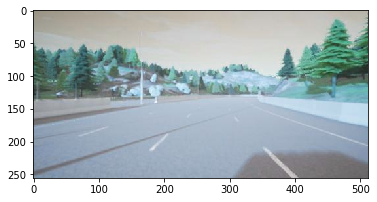

In [80]:
rand = np.random.randint(500)
plt.imshow(X_test[rand,:,:,:])

In [81]:
inst_pred[0].shape

(256, 512, 4)

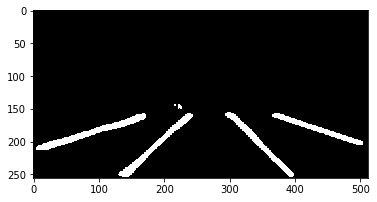

In [82]:
plt.imshow((bin_pred[rand,:,:,0] > 0.22).astype(np.uint8), cmap='gray')

In [31]:
a=tf.nn.softmax(bin_pred[rand], axis=1)
np.unique(np.array(a))

array([0.00147344, 0.00147457, 0.00147523, ..., 0.00236585, 0.00236901,
       0.00236979], dtype=float32)

In [ ]:
plt.imshow(a[:,:,0])

In [ ]:
plt.imshow(tf.math.sigmoid(inst_pred[rand,:,:,3]), cmap='gray')

In [ ]:
b = (bin_pred[rand,:,:,0] > 0.2).astype(np.uint8)
p = tf.math.sigmoid(inst_pred[rand,:,:,1])
ap = (b*p*255)
plt.imshow(ap)

In [ ]:
def minmax_scale(input_arr):
    """

    :param input_arr:
    :return:
    """
    min_val = np.min(input_arr)
    max_val = np.max(input_arr)

    output_arr = (input_arr - min_val) * 255.0 / (max_val - min_val)

    return output_arr
    

In [ ]:
for i in range(4):
    inst_pred[rand,:,:,i] = minmax_scale(np.array(inst_pred[rand][:, :, i]))
    embedding_image = np.array(inst_pred[rand], np.uint8)
h = (bin_pred[rand,:,:,:] > 0.2).astype(np.uint8)
plt.imshow(embedding_image[:,:,(2,1,0)]*h)

In [ ]:
h = (bin_pred[rand,:,:,:] > 0.2).astype(np.uint8)
s = h[:,:,(0,0,0)]

In [ ]:
plt.imshow(embedding_image[:,:,(2,1,0)])

In [ ]:
dst = cv2.addWeighted((image_ds[rand,:,:,:]*255).astype(int), 0.5, ap, 1, 0.0)
dst
plt.imshow(dst)

In [ ]:
for i in range(1999):
    b = (bin_pred[i,:,:,0] > 0.37).astype(np.uint8)
    p = inst_pred[i,:,:,:]
    b = cv2.cvtColor(b, cv2.COLOR_GRAY2BGR)
    ap = (b*p*255).astype(int)
    dst = cv2.addWeighted((image_ds[i,:,:,:]*255).astype(int), 0.5, ap, 0.5, 0.0)
    dst = dst.astype(np.uint8)
    cv2.imshow('restult', dst)
    cv2.waitKey(10)

In [ ]:
_, acc = model.evaluate(X_test, [bin_test, inst_test])
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
#acc = history.history['accuracy']
val_acc = history.history['val_acc']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#bin_pred, ins=model.predict(X_test)
y_pred_thresholded = bin_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
model.load_weights('lanenet_20211223_instance.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.3).astype(np.uint8)

In [ ]:
image_ds[0].shape

In [ ]:
#test_img_other = image_ds[0]
#test_img_other = cv2.imread('data/training_data_example/image/0000.png', 0)
test_img_other = cv2.imread('D:/Project/IrohXu_LaneDetection/data/CARLA/images/00005649.png')
test_img_other = Image.fromarray(test_img_other)
test_img_other = test_img_other.resize((512, 256))
test_img_other_norm = np.array(test_img_other)/255.0
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

with tf.device('device:GPU:0'):
    bin_pred, inst_pred = model.predict(test_img_other_input)
    prediction_other = (bin_pred[0,:,:,0] > 0.3).astype(np.uint8)

In [ ]:
plt.imshow(inst_pred[0])

In [ ]:
test_img_other = cv2.imread('dataset/val/images/Town04_Clear_Noon_09_09_2020_14_57_22_frame_633_validation_set.png')
test_img_other = Image.fromarray(test_img_other)
test_img_other = test_img_other.resize((512, 256))
test_img_other_norm = np.array(test_img_other)/255.0
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

bin_pred, inst_pred = model.predict(test_img_other_input)

In [ ]:
inst_pred = inst_pred*255.0

In [ ]:
print(inst_pred)

In [ ]:
prediction_other = (bin_pred[0,:,:,0] > 0.5).astype(np.uint8)
#huf0 = (inst_pred[0][:,:,0] < 120).astype(np.uint8)
#huf1 = (inst_pred[0][:,:,1] < 120).astype(np.uint8)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.title('Input Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(222)
plt.title('Prediction of Lane')
plt.imshow(prediction_other, cmap='gray')
plt.subplot(223)
plt.title('Prediction of Left Lane')
plt.imshow(inst_pred[0])
plt.subplot(224)
plt.title('Prediction of Right Lane')
plt.imshow(huf1, cmap='gray')
plt.show()